In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from math import ceil, log2
from sklearn.ensemble import RandomForestClassifier
import openml
from simple_model import  ConformalPredictor, ConformalRankingPredictor, ClassifierModel, LabelRankingModel
import matplotlib.pyplot as plt

In [3]:
def evaluate_models(dataset_id):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, _, _ = dataset.get_data(
        target=dataset.default_target_attribute, dataset_format="dataframe"
    )

    # Automatically identify categorical and numerical columns
    categorical_features = X.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

    num_classes = len(np.unique(y))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1
    )

    # Encode labels
    le = LabelEncoder()

    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # Preprocessing for numerical data: Impute missing values, then scale
    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
        ]
    )

    # Preprocessing for categorical data: Impute missing values, then one-hot encode
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    if not isinstance(X_train, np.ndarray):
        X_train = X_train.toarray()
    if not isinstance(y_train, np.ndarray):
        y_train = y_train.toarray()

    # clf = ClassifierModel(input_dim = X_train.shape[1], hidden_dim=16, output_dim=y.max()+1)
    rf = RandomForestClassifier()

    clf = ClassifierModel(input_dim=X_train.shape[1], hidden_dim=16, output_dim=num_classes)
    rank = LabelRankingModel(input_dim=X_train.shape[1], hidden_dim=16, output_dim=num_classes)

    num_classes = len(np.unique(y_train))

    batch_size_clf = 32
    val_frac = 0.2
    cal_frac = 1/3
    num_epochs = 35
    learning_rate = 0.01

    cp_net = ConformalPredictor(clf, alpha=0.05)
    cp_rf = ConformalPredictor(rf, alpha=0.05)
    cp_rank = ConformalPredictor(rank, alpha=0.05)

    cp_net.fit(X_train, y_train, num_epochs=num_epochs, random_state=1, patience=num_epochs, batch_size=batch_size_clf, val_frac=val_frac, cal_size=cal_frac, learning_rate=learning_rate)
    cp_rank.fit(X_train, y_train, num_epochs=num_epochs, random_state=1, patience=num_epochs, batch_size=batch_size_clf, val_frac=val_frac, cal_size=cal_frac, learning_rate=learning_rate)
    cp_rf.fit(X_train, y_train, cal_size=cal_frac)

    if not isinstance(X_test, np.ndarray):
        X_test = X_test.toarray()
    if not isinstance(y_test, np.ndarray):
        y_test = y_test.toarray()

    def evaluate_method(method):
        pred_sets = method.predict_set(X_test)
        y_test_model = method.model.predict(X_test)
        coverage = np.mean([y_test[i] in pred_sets[i] for i in range(len(y_test))])
        efficiency = np.mean([len(pred_sets[i]) for i in range(len(y_test))])
        print(f"Accuracy {accuracy_score(y_test_model, y_test)}")
        print(f"Coverage {coverage} efficiency {efficiency}")

    # coverage_clf = np.mean([y_test[i] in pred_sets_clf[i] for i in range(len(y_test))])
    # efficiency_clf = np.mean([len(pred_sets_clf[i]) for i in range(len(y_test))])

    print("Random Forest")
    evaluate_method(cp_rf)
    print("\nClassifier Network")
    evaluate_method(cp_net)
    print("\nRanking Network")
    evaluate_method(cp_rank)
for dataset_id in [61, 187, 15, 31, 4534, 1461]:
    print(f"\n\nDataset: {dataset_id}")
    evaluate_models(dataset_id)




Dataset: 61


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9666666666666667
Coverage 1.0 efficiency 1.0333333333333334

Classifier Network
Accuracy 0.9666666666666667
Coverage 0.9666666666666667 efficiency 1.0

Ranking Network
Accuracy 0.9666666666666667
Coverage 0.8666666666666667 efficiency 0.9


Dataset: 187


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9722222222222222
Coverage 0.9722222222222222 efficiency 1.0277777777777777

Classifier Network
Accuracy 1.0
Coverage 1.0 efficiency 1.0

Ranking Network
Accuracy 1.0
Coverage 1.0 efficiency 1.0277777777777777


Dataset: 15


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9785714285714285
Coverage 0.9714285714285714 efficiency 0.9857142857142858

Classifier Network
Accuracy 0.9785714285714285
Coverage 0.9785714285714285 efficiency 1.0

Ranking Network
Accuracy 0.9785714285714285
Coverage 0.9785714285714285 efficiency 1.0


Dataset: 31


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.75
Coverage 0.93 efficiency 1.515

Classifier Network
Accuracy 0.755
Coverage 0.955 efficiency 1.585

Ranking Network
Accuracy 0.745
Coverage 0.955 efficiency 1.595


Dataset: 4534


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9656264133876075
Coverage 0.9425599276345545 efficiency 0.9611035730438715

Classifier Network
Accuracy 0.9502487562189055
Coverage 0.9488919041157847 efficiency 0.9977385798281321

Ranking Network
Accuracy 0.9402985074626866
Coverage 0.939846223428313 efficiency 0.9990954319312528


Dataset: 1461


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


KeyboardInterrupt: 

In [4]:
from simple_model import LabelPairDataset

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X,y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3)
num_classes = len(np.unique(y))


In [6]:
from simple_model import LabelRankingModel
model = LabelRankingModel(input_dim=X_train.shape[1],hidden_dim=16, output_dim=3)
model.fit(X_train,y_train,num_classes=3, random_state=1, batch_size=32, num_epochs=250,patience=250)

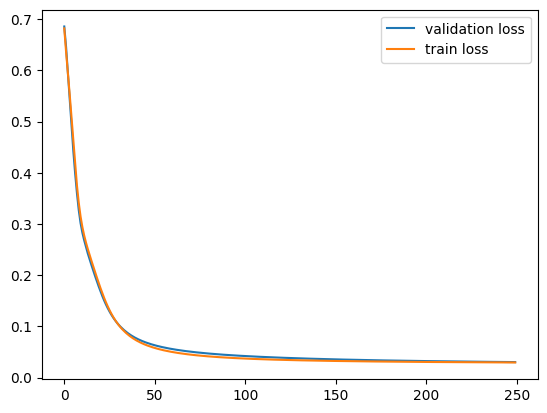

In [7]:
plt.plot(np.arange(len(model.val_losses)), model.val_losses, label="validation loss")
plt.plot(np.arange(len(model.train_losses)), model.train_losses, label="train loss")
plt.legend()
plt.show()

In [8]:
y_pred = model.predict(X_test)

In [9]:
accuracy_score(y_pred,y_test)

0.98

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

batch_size = 64

# Training and test data loaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# # Step 2: Load the pre-trained ResNet18 model
# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features

# # Modify the final layer for 10 classes (CIFAR-10)
# model.fc = nn.Linear(num_ftrs, 10)
# model = model.to(device)

# # Step 3: Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Step 4: Train the model
# epochs = 5
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in trainloader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}')

# # Step 5: Evaluate the model on the test set
# model.eval()
# correct = 0
# total = 0

# with torch.no_grad():
#     for inputs, labels in testloader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {100 * correct / total:.2f}%')


Files already downloaded and verified
Files already downloaded and verified


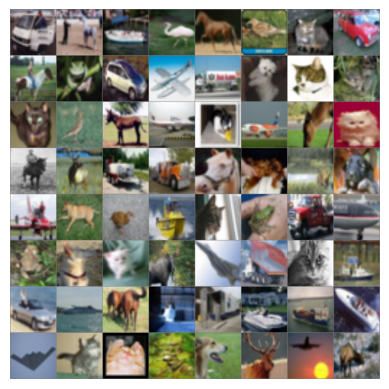

truck horse ship bird


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Define a function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image (reverse the normalization)
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to (H, W, C)
    plt.axis('off')  # Turn off axis
    plt.show()

# Step 3: Get a batch of images and display them
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Get a batch of images and labels

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show images
imshow(torchvision.utils.make_grid(images))  # Display the images in a grid

# Print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [12]:

probs = np.load("data/cifar10h-probs.npy")
counts = np.load("data/cifar10h-counts.npy")


In [13]:
def show_pic_and_probs(k):
    df = pd.DataFrame({'classes': classes, 'counts': counts[k], 'probabilities': probs[k]})
    imshow(testset[k][0])
    display(df)

In [14]:
probs.shape

(10000, 10)

In [15]:
epsilon = 1e-10
entropy = -np.sum(probs * np.log2(probs + epsilon), axis=1)
high_confusion = np.argsort(entropy)[::-1][:5]
high_confusion

array([6750, 8153, 6792,   86, 2232])

In [234]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import itertools


class CIFAR10SoftLabelComparisonDataset(Dataset):
    def __init__(self, cifar_dataset, soft_labels, num_pairs=1000, in_instance_ratio=0.5):
        """
        Args:
            cifar_dataset (torchvision.datasets.CIFAR10): CIFAR-10 dataset object.
            soft_labels (numpy.ndarray): Array of shape (N, num_classes) with soft labels.
            num_pairs (int): Total number of pairs to generate.
            in_instance_ratio (float): Ratio of in-instance comparisons (between 0 and 1).
        """
        self.cifar_dataset = cifar_dataset
        self.soft_labels = torch.tensor(soft_labels, dtype=torch.float32)  # Convert to torch tensor
        self.num_samples = len(cifar_dataset)
        self.num_classes = soft_labels.shape[1]
        self.num_pairs = num_pairs
        self.in_instance_ratio = in_instance_ratio

        # Determine how many pairs are in-instance and cross-instance
        self.num_in_instance = int(num_pairs * in_instance_ratio)
        self.num_cross_instance = num_pairs - self.num_in_instance

        # Precompute deterministic pairs
        self.in_instance_pairs = self._generate_in_instance_pairs()
        self.cross_instance_pairs = self._generate_cross_instance_pairs()

    def _generate_in_instance_pairs(self):
        """
        Generate in-instance pairs: (image, class1, class2) such that prob(class1|image) > prob(class2|image).
        Returns:
            list: List of (idx, class1, class2, prob1, prob2).
        """
        in_instance_pairs = []

        for idx in range(self.num_samples):
            label_probs = self.soft_labels[idx]
            for class1 in range(self.num_classes):
                for class2 in range(self.num_classes):
                    if class1 != class2 and label_probs[class1] > label_probs[class2]:
                        in_instance_pairs.append(
                            (idx, class1, class2, label_probs[class1].item(), label_probs[class2].item())
                        )

        # Shuffle and select a fixed number of in-instance pairs
        np.random.shuffle(in_instance_pairs)
        return in_instance_pairs[:self.num_in_instance]

    def _generate_cross_instance_pairs(self):
        """
        Generate cross-instance pairs: (image1, class1, image2, class2) where prob(class1|image1) > prob(class2|image2).
        Returns:
            list: List of (idx1, class1, idx2, class2, prob1, prob2).
        """
        cross_instance_pairs = []

        for _ in range(self.num_samples * 2):  # Generate more candidates than needed
            idx1, idx2 = np.random.choice(self.num_samples, size=2, replace=False)
            label_probs1 = self.soft_labels[idx1]
            label_probs2 = self.soft_labels[idx2]

            for class1 in range(self.num_classes):
                for class2 in range(self.num_classes):
                    if label_probs1[class1] > label_probs2[class2]:
                        cross_instance_pairs.append(
                            (idx1, class1, idx2, class2, label_probs1[class1].item(), label_probs2[class2].item())
                        )

        # Shuffle and select a fixed number of cross-instance pairs
        np.random.shuffle(cross_instance_pairs)
        return cross_instance_pairs[:self.num_cross_instance]

    def __len__(self):
        return self.num_pairs

    def __getitem__(self, idx):
        """
        Returns:
            img1 (Tensor): First image in the comparison.
            class1 (int): Class index for the first image.
            prob1 (float): Probability of the class for the first image.
            img2 (Tensor): Second image in the comparison.
            class2 (int): Class index for the second image.
            prob2 (float): Probability of the class for the second image.
        """
        if idx < self.num_in_instance:
            # Return an in-instance pair
            idx, class1, class2, prob1, prob2 = self.in_instance_pairs[idx]
            img1, _ = self.cifar_dataset[idx]
            return img1, class1, prob1, img1, class2, prob2
        else:
            # Return a cross-instance pair
            idx = idx - self.num_in_instance
            idx1, class1, idx2, class2, prob1, prob2 = self.cross_instance_pairs[idx]
            img1, _ = self.cifar_dataset[idx1]
            img2, _ = self.cifar_dataset[idx2]
            return img1, class1, prob1, img2, class2, prob2


# Example usage
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

soft_labels = probs

# Create the comparison dataset with deterministic 60% in-instance, 40% cross-instance pairs
comparison_dataset = CIFAR10SoftLabelComparisonDataset(
    cifar_dataset, soft_labels, num_pairs=1000, in_instance_ratio=0.6
)

# Access a sample pair
img1, class1, prob1, img2, class2, prob2 = comparison_dataset[0]
print(f"Image1 (Class {class1}, Prob {prob1:.2f}) vs Image2 (Class {class2}, Prob {prob2:.2f})")


Files already downloaded and verified
Image1 (Class 3, Prob 0.02) vs Image2 (Class 9, Prob 0.00)


In [235]:
def visualize_pair(img1, class1, prob1, img2, class2, prob2, class_names):
    """
    Visualize a comparison pair, including the images, their labels, and probabilities.
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Image 1
    axes[0].imshow(img1.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    axes[0].set_title(f"Class {class1} ({class_names[class1]})\nProb: {prob1:.2f}")
    axes[0].axis('off')

    # Image 2
    axes[1].imshow(img2.permute(1, 2, 0))
    axes[1].set_title(f"Class {class2} ({class_names[class2]})\nProb: {prob2:.2f}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


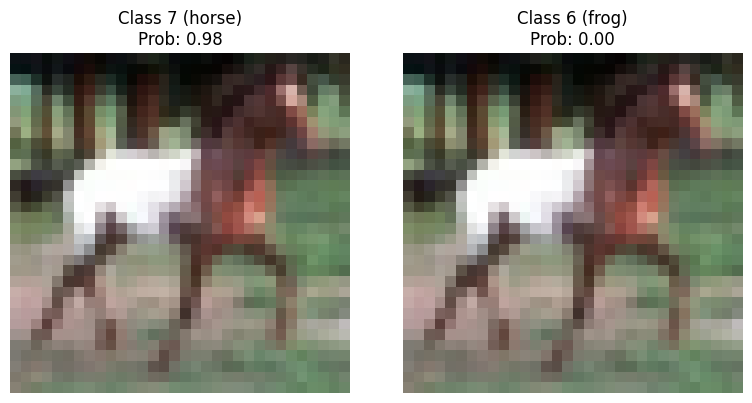

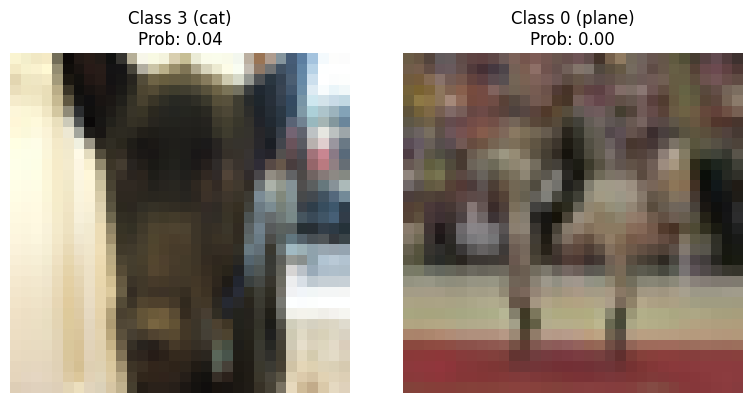

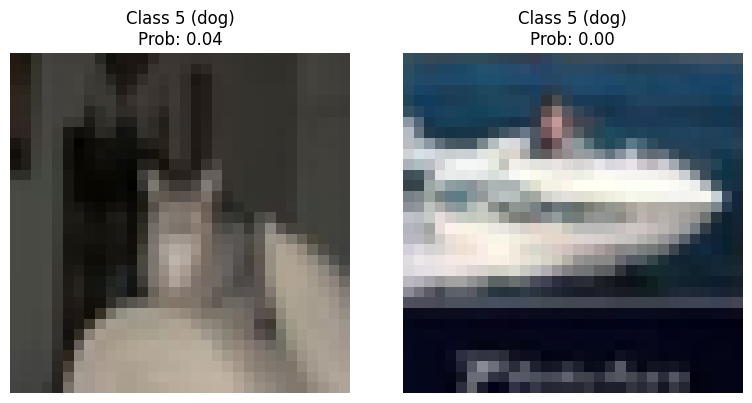

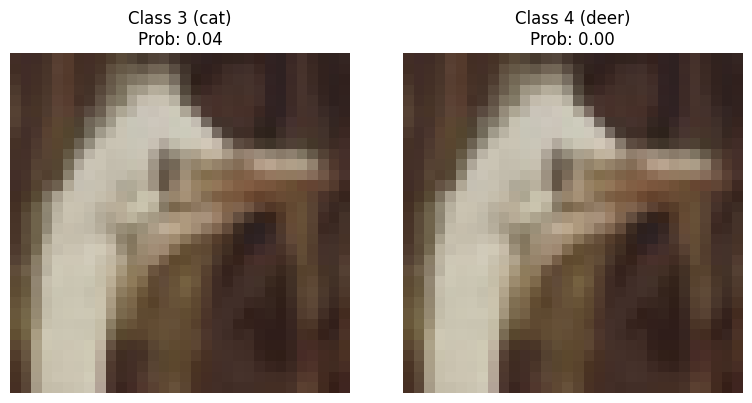

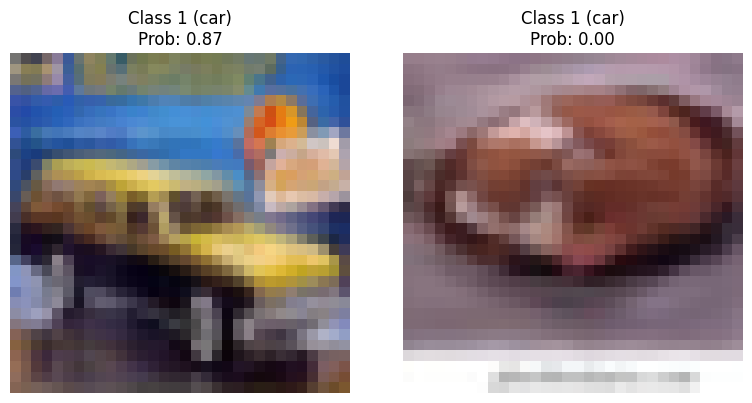

In [238]:
from torch.utils.data import DataLoader
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 1
loader = iter(DataLoader(comparison_dataset, batch_size=batch_size, shuffle=True))


for _ in range(5):
    img1_b, class1_b, prob1_b, img2_b, class2_b, prob2_b = next(loader)
    for i in range(batch_size):
        img1, class1, prob1, img2, class2, prob2 = img1_b[i], class1_b[i], prob1_b[i], img2_b[i], class2_b[i], prob2_b[i]
        visualize_pair(img1, class1, prob1, img2, class2, prob2, class_names)
    # for (img1, class1, prob1, img2, class2, prob2) in batch:

In [ ]:
def get_rowwise_pairs(probs, i_threshold=None, j_threshold=None):
    result = []
    for row_idx, row in enumerate(probs):
        i_indices, j_indices = np.where(row[:, None] > row)
        if i_threshold is not None:
            mask_i = row[i_indices] > i_threshold
            i_indices, j_indices = i_indices[mask_i], j_indices[mask_i]
        if j_threshold is not None:
            mask_j = row[j_indices] > j_threshold
            i_indices, j_indices = i_indices[mask_j], j_indices[mask_j]
        pairs = np.column_stack((np.full(i_indices.shape, row_idx), i_indices, j_indices))
        result.append(pairs)
    try:
        result = np.vstack(result)
    except:
        result = np.array([])
    return result

def get_rowwise_pairs_with_max(matrix, j_threshold=None):
    result = []
    for row_idx, row in enumerate(matrix):
        max_value = np.max(row)
        max_ids = np.argwhere(row==max_value)
        print(max_ids)
        for max_idx in max_ids:
            j_indices = np.where(row < max_value)[0]
            if j_threshold is not None:
                j_indices = j_indices[row[j_indices] > j_threshold]
            
            pairs = np.column_stack((np.full(j_indices.shape, row_idx), np.full(j_indices.shape, max_idx), j_indices))
        result.append(pairs)
    try:
        result = np.vstack(result)
    except:
        result = np.array([])
    return result

def get_cross_row_pairs(matrix):
    num_rows, num_cols = matrix.shape
    result = []
    # Iterate over all pairs of rows (k, l)
    for k in range(num_rows):
        for l in range(num_rows):
            if k != l:
                # Compare all pairs of elements from row k and row l
                i_indices, j_indices = np.where(matrix[k][:, None] > matrix[l])
                # Combine row indices (k, l) with column indices (i, j)
                pairs = np.column_stack((np.full(i_indices.shape, k), i_indices, np.full(j_indices.shape, l), j_indices))
                result.append(pairs)
    try:
        result = np.stack(result)
    except:
        result = np.array([])
    return result


def get_cross_row_pairs_with_max(matrix):
    num_rows, num_cols = matrix.shape
    result = []
    # Iterate over all pairs of rows (k, l)
    for k in range(num_rows):
        max_k = np.max(matrix.k)
        for l in range(num_rows):
            max_l = np.max(matrix.k)
            if k != l:
                # Compare all pairs of elements from row k and row l
                i_indices, j_indices = np.where(matrix[k][:, None] > matrix[l])
                # Combine row indices (k, l) with column indices (i, j)
                pairs = np.column_stack((np.full(i_indices.shape, k), i_indices, np.full(j_indices.shape, l), j_indices))
                result.append(pairs)
    try:
        result = np.stack(result)
    except:
        result = np.array([])
    return result

In [214]:
pairs = get_rowwise_pairs_with_max(probs[9244:9248])

[[7]]
[[1]]
[[3]
 [4]]
[[9]]


In [215]:
np.vstack(pairs)

array([[0, 7, 0],
       [0, 7, 1],
       [0, 7, 2],
       [0, 7, 3],
       [0, 7, 4],
       [0, 7, 5],
       [0, 7, 6],
       [0, 7, 8],
       [0, 7, 9],
       [1, 1, 0],
       [1, 1, 2],
       [1, 1, 3],
       [1, 1, 4],
       [1, 1, 5],
       [1, 1, 6],
       [1, 1, 7],
       [1, 1, 8],
       [1, 1, 9],
       [2, 4, 0],
       [2, 4, 1],
       [2, 4, 2],
       [2, 4, 5],
       [2, 4, 6],
       [2, 4, 7],
       [2, 4, 8],
       [2, 4, 9],
       [3, 9, 0],
       [3, 9, 1],
       [3, 9, 2],
       [3, 9, 3],
       [3, 9, 4],
       [3, 9, 5],
       [3, 9, 6],
       [3, 9, 7],
       [3, 9, 8]])

In [216]:
row_max = np.max(probs, axis=1)

# Step 2: Check how many times the maximum value occurs in each row
is_not_unique = np.sum(probs == row_max[:, None], axis=1) > 1

# Step 3: Get the indices of rows where the maximum is not unique
rows_with_non_unique_max = np.where(is_not_unique)[0]

In [217]:
rows_with_non_unique_max

array([7493, 9246, 9386])

In [11]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()

In [12]:
imshow(testset[32][0])

NameError: name 'plt' is not defined

In [13]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

c:\Users\jonas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jonas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
from torch.utils.data import Subset
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

subset = Subset(test_dataset, indices=range(0,5))

Files already downloaded and verified


In [15]:
subset_loader = torch.utils.data.DataLoader(dataset=subset, batch_size=batch_size, shuffle=False)

In [16]:
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in subset_loader:
        # images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(subset_loader):.4f}")


Epoch [1/50], Loss: 2.7673
Epoch [2/50], Loss: 0.1384
Epoch [3/50], Loss: 0.0079
Epoch [4/50], Loss: 0.0022
Epoch [5/50], Loss: 0.0009
Epoch [6/50], Loss: 0.0005
Epoch [7/50], Loss: 0.0003
Epoch [8/50], Loss: 0.0002
Epoch [9/50], Loss: 0.0001
Epoch [10/50], Loss: 0.0001
Epoch [11/50], Loss: 0.0001
Epoch [12/50], Loss: 0.0001
Epoch [13/50], Loss: 0.0001
Epoch [14/50], Loss: 0.0001
Epoch [15/50], Loss: 0.0001
Epoch [16/50], Loss: 0.0000
Epoch [17/50], Loss: 0.0000
Epoch [18/50], Loss: 0.0000
Epoch [19/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [21/50], Loss: 0.0000
Epoch [22/50], Loss: 0.0000
Epoch [23/50], Loss: 0.0000
Epoch [24/50], Loss: 0.0000
Epoch [25/50], Loss: 0.0000
Epoch [26/50], Loss: 0.0000
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [31/50], Loss: 0.0000
Epoch [32/50], Loss: 0.0000
Epoch [33/50], Loss: 0.0000
Epoch [34/50], Loss: 0.0000
Epoch [35/50], Loss: 0.0000
Epoch [36/50], Loss: 0.0000
E

In [17]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in subset_loader:
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
with torch.no_grad():

    for image, label in subset_loader:
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        imshow(image)
        print(softmax(outputs.cpu().numpy()))
        print("true label:", class_names[label])
        print("predicted label:", class_names[predicted])


NameError: name 'np' is not defined

In [ ]:
for image, label in subset

torch.Size([1, 3, 224, 224])